In [27]:
import numpy as np
import pandas as pd
from itertools import combinations

df = pd.read_csv("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/smplx_multiview_diff_coord/vertex_heatmaps/vertex_heatmaps.csv")

df["effective_vertices"] = df["effective_vertices"].apply(lambda x: eval(x))
df["effective_vertices"] = df["effective_vertices"].apply(lambda x: np.array(x))

# get all permutations of pairs of descriptors
combs = list(combinations(df["descriptor"].values, 2))

# for each pair calc iou and save to df
ious_df = pd.DataFrame()
for comb in combs:
    comb_df = df[df["descriptor"].isin(comb)]
    comb_df = comb_df.sort_values("descriptor")
    iou = len(np.intersect1d(comb_df["effective_vertices"].values[0], comb_df["effective_vertices"].values[1])) / len(np.union1d(comb_df["effective_vertices"].values[0], comb_df["effective_vertices"].values[1]))
    ious_df = pd.concat([ious_df, pd.DataFrame((comb[0], comb[1], iou)).T])

# sort by iou
columns=("descriptor_1", "descriptor_2", "iou")
ious_df.columns = columns
ious_df = ious_df.sort_values("iou", ascending=False)
ious_df.to_csv("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/smplx_multiview_diff_coord/vertex_heatmaps/ious.csv", index=False)

In [44]:
import cv2
import pandas as pd

df = pd.read_csv("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/smplx_multiview_diff_coord/vertex_heatmaps/ious.csv")
for i, row in df.iterrows():
    img1 = cv2.imread(f"/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/smplx_multiview_diff_coord/vertex_heatmaps/{row['descriptor_1']}.png")
    img2 = cv2.imread(f"/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/smplx_multiview_diff_coord/vertex_heatmaps/{row['descriptor_2']}.png")
    cv2.putText(img1, f"{row['descriptor_1']}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 2)
    cv2.putText(img2, f"{row['descriptor_2']}", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 2)
    cv2.putText(img1, f"{row['iou']:.2f}", (2000, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 2)
    img = np.concatenate((img1, img2), axis=0)
    img = cv2.resize(img, (1700, 1000), fx=0.5, fy=0.5)
    cv2.imshow("img", img)
    key = cv2.waitKey(0)
    if key == ord("q"):
        break
        
cv2.destroyAllWindows()

In [62]:
[list(descriptors_groups.values())]

[[['muscular',
   'short',
   'long legs',
   'curvy',
   'lean',
   'masculine',
   'proportioned',
   'sexy',
   'sturdy',
   'hourglass',
   'fit',
   'round apple',
   'built',
   'petite'],
  ['fat',
   'thin',
   'narrow waist',
   'skinny',
   'tall',
   'average',
   'big',
   'broad shoulders'],
  ['rectangular', 'pear shaped', 'stocky', 'heavyset', 'small']]]

In [156]:
import json
import pandas as pd

df = pd.read_csv("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/compared_to_inv/flame_exp_multiview_l2/vertex_heatmaps/ious.csv")
descriptors_groups_json = "/home/nadav2/dev/data/CLIP2Shape/outs/clustering_images/words_jsons/flame_expression.json"
descriptors_groups = json.load(open(descriptors_groups_json, "r"))

for group_idx, descriptors in descriptors_groups.items():
    group_df = df[df["descriptor_1"].isin(descriptors) & df["descriptor_2"].isin(descriptors)]
    group_df = group_df.sort_values("iou", ascending=False)
    print(group_df)
    group_df.to_csv(f"/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/compared_to_def/flame_exp_multiview_l2/vertex_heatmaps/ious_{group_idx}.csv", index=False)

   descriptor_1 descriptor_2       iou
8         happy   open mouth  0.361963
22        smile    disgusted  0.035398
37        smile   open mouth  0.007143
44        smile        happy  0.000000
71        happy    disgusted  0.000000
77   open mouth    disgusted  0.000000
   descriptor_1 descriptor_2       iou
1     surprised          sad  0.872093
33    open eyes        angry  0.008929
39    surprised        angry  0.000000
40        angry          sad  0.000000
60    open eyes    surprised  0.000000
61    open eyes          sad  0.000000


In [148]:
import pandas as pd


def choose_between_2_descriptors(df, first_descriptor, second_descriptor):
    first_descriptor_avg_iou = df[(df["descriptor_1"] == first_descriptor) | (df["descriptor_2"] == first_descriptor)]["iou"].mean()
    second_descriptor_avg_iou = df[(df["descriptor_1"] == second_descriptor) | (df["descriptor_2"] == second_descriptor)]["iou"].mean()
    print(f"{first_descriptor} iou: {first_descriptor_avg_iou}")
    print(f"{second_descriptor} iou: {second_descriptor_avg_iou}")
    if first_descriptor_avg_iou < second_descriptor_avg_iou:
        print(f"chose {first_descriptor} with iou {first_descriptor_avg_iou}")
        return first_descriptor, first_descriptor_avg_iou         
    else:
        print(f"chose {second_descriptor} with iou {second_descriptor_avg_iou}")
        return second_descriptor, second_descriptor_avg_iou

max_possible_candiates = 6
finalists_descriptors = {}
for iou_group in range(3):
    df = pd.read_csv(f"/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/compared_to_def/smplx_multiview_diff_coord/vertex_heatmaps/ious_{iou_group}.csv")

    # split the descriptors to two groups, one above iou=0.7 and one below
    df["group"] = df["iou"].apply(lambda x: 1 if x > 0.7 else 0)
    final_candidates = {}
    for group_idx in df["group"].unique():
        chosed_descriptors = {}
        for idx, row in df[df["group"] == group_idx].iterrows():
            print(f"*"*50)
            print("choosing between:", row["descriptor_1"], row["descriptor_2"])
            first_descriptor = row["descriptor_1"]
            second_descriptor = row["descriptor_2"]
            
            chosen_descriptor, chosen_descriptor_iou = choose_between_2_descriptors(df, first_descriptor, second_descriptor)
            if chosen_descriptor not in chosed_descriptors.keys():
                if chosed_descriptors == {}:
                    print("first descriptor is chosen", chosen_descriptor)
                    chosed_descriptors[chosen_descriptor] = chosen_descriptor_iou
                else:
                    print("iterating over chosed descriptors", chosed_descriptors)
                    add_descriptor = False
                    for descriptor in chosed_descriptors.keys():
                        print("choosing between", descriptor, chosen_descriptor)
                        sub_chosen_descriptor, _ = choose_between_2_descriptors(df, descriptor, chosen_descriptor)
                        if sub_chosen_descriptor != chosen_descriptor:
                            print(f"{chosen_descriptor} has higher iou than {descriptor}, hence {descriptor} is chosen")
                            break
                        else:
                            add_descriptor = True
                    if add_descriptor:
                        print(f"{chosen_descriptor} has lower iou than all chosed descriptors, hence {chosen_descriptor} is chosen")
                        chosed_descriptors[chosen_descriptor] = chosen_descriptor_iou
            
            print(chosed_descriptors)


        # sorted_chosed_descriptors = sorted(chosed_descriptors, key=chosed_descriptors.get, reverse=False)
        for descriptor, iou in chosed_descriptors.items():
            if descriptor not in final_candidates.keys():
                final_candidates[descriptor] = iou

    print(f"*" * 50)
    possible_options = df["descriptor_1"].unique().tolist()
    possible_options= possible_options + [item for item in df["descriptor_2"].unique() if item not in possible_options]
    print("possible_options:", possible_options, len(possible_options))
    print("final candidates:", final_candidates, len(final_candidates))
    finalists_descriptors[iou_group] = sorted(final_candidates, key=final_candidates.get, reverse=False)[:max_possible_candiates]


print(finalists_descriptors)

**************************************************
choosing between: lean fit
lean iou: 0.5006575413655235
fit iou: 0.5014886596287411
chose lean with iou 0.5006575413655235
first descriptor is chosen lean
{'lean': 0.5006575413655235}
**************************************************
choosing between: masculine fit
masculine iou: 0.5025573347787001
fit iou: 0.5014886596287411
chose fit with iou 0.5014886596287411
iterating over chosed descriptors {'lean': 0.5006575413655235}
choosing between lean fit
lean iou: 0.5006575413655235
fit iou: 0.5014886596287411
chose lean with iou 0.5006575413655235
fit has higher iou than lean, hence lean is chosen
{'lean': 0.5006575413655235}
**************************************************
choosing between: lean masculine
lean iou: 0.5006575413655235
masculine iou: 0.5025573347787001
chose lean with iou 0.5006575413655235
{'lean': 0.5006575413655235}
**************************************************
choosing between: petite fit
petite iou: 0.49743908

In [149]:
finalists_descriptors

{0: ['long legs',
  'round apple',
  'curvy',
  'proportioned',
  'sturdy',
  'muscular'],
 1: ['narrow waist', 'big', 'fat'],
 2: ['stocky', 'heavyset', 'pear shaped']}

In [154]:
df = pd.read_csv(f"/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/optimizations/compared_to_def/smplx_multiview_diff_coord/vertex_heatmaps/ious_{1}.csv")
choose_between_2_descriptors(df,finalists_descriptors[1][2], finalists_descriptors[1][0])

fat iou: 0.3941237560877649
narrow waist iou: 0.12783751218931452
chose narrow waist with iou 0.12783751218931452


('narrow waist', 0.12783751218931452)

In [91]:
print("lean", df[(df["descriptor_1"] == "lean") | (df["descriptor_2"] == "lean")]["iou"].sum())
print("fit", df[(df["descriptor_1"] == "fit") | (df["descriptor_2"] == "fit")]["iou"].sum())


lean 6.007890496386282
fit 6.017863915544893


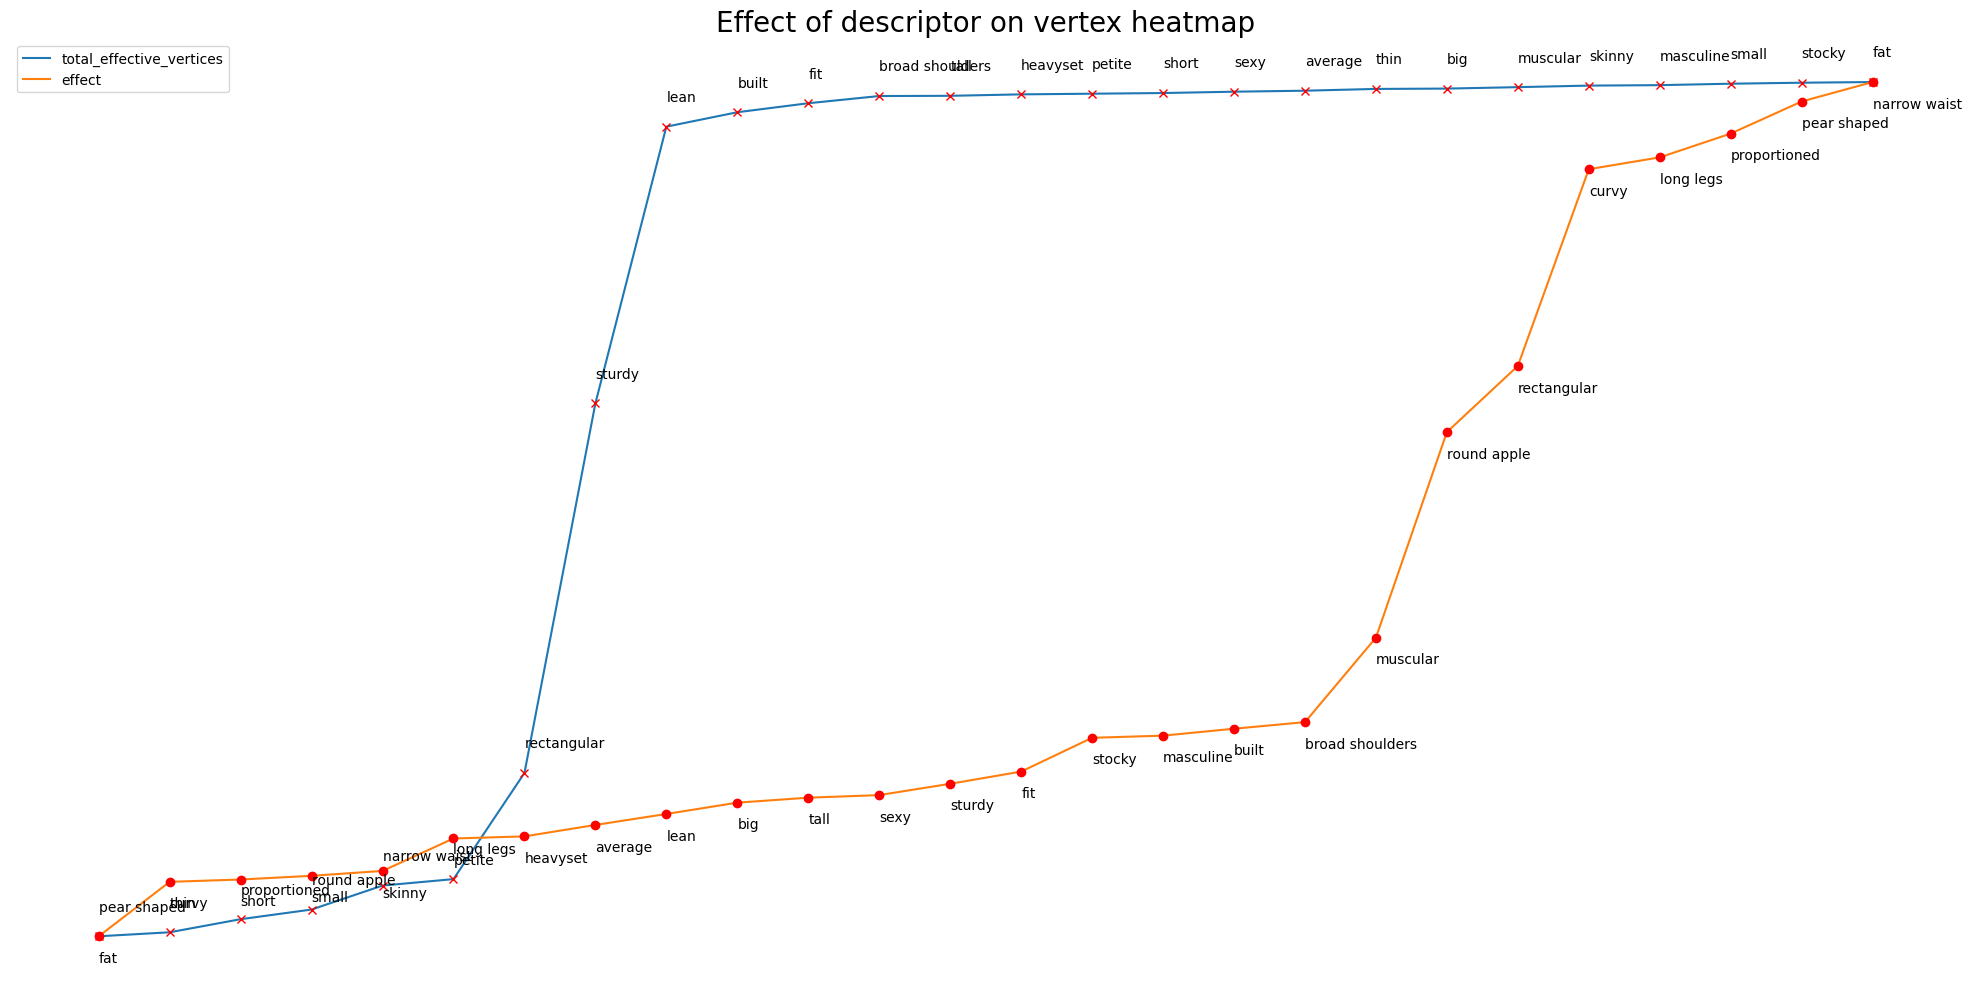

In [308]:
# plot the effect values sorted by effect value and add the name of the descriptor
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
# normalize df["total_effective_vertices"].values to be between 0 and 1 and sort by value
normalized_effective_vertices = (df["total_effective_vertices"].values - df["total_effective_vertices"].values.min()) / (df["total_effective_vertices"].values.max() - df["total_effective_vertices"].values.min())
normalized_effective_vertices_sorted = np.argsort(normalized_effective_vertices)
normalized_effect = (df["effect"].values - df["effect"].values.min()) / (df["effect"].values.max() - df["effect"].values.min())
normalized_effect_sorted = np.argsort(normalized_effect)

plt.plot(np.linspace(0, 1, len(df)), normalized_effective_vertices[normalized_effective_vertices_sorted], label="total_effective_vertices")
for i, effect, name in zip(np.linspace(0, 1, len(df)), normalized_effective_vertices[normalized_effective_vertices_sorted], df["descriptor"][normalized_effective_vertices_sorted].values):
    plt.text(i, effect + 0.03, name, fontsize=10)
    plt.plot(i, effect, "x", color="red")

plt.plot(np.linspace(0, 1, len(df)), normalized_effect[normalized_effect_sorted], label="effect")
for i, effect, name in zip(np.linspace(0, 1, len(df)), normalized_effect[normalized_effect_sorted], df["descriptor"][normalized_effect_sorted].values):
    plt.text(i, effect - 0.03, name, fontsize=10)
    plt.plot(i, effect, "o", color="red")

plt.title("Effect of descriptor on vertex heatmap", fontsize=20)
plt.legend()
plt.axis("off")
fig.tight_layout()
fig.savefig("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/outs/plots/vertex_heatmap_stats_smplx.png")

In [ ]:
# # normalize df["effect"].values to be between 0 and 1
# plt.plot((df["effect"].values - df["effect"].values.min()) / (df["effect"].values.max() - df["effect"].values.min()))


# # normalize df["effect"].values to be between 0 and 1
# plt.plot((df["effect"].values - df["effect"].values.min()) / (df["effect"].values.max() - df["effect"].values.min()))

# # add text to the plot with the name of the descriptor abd a dot at the effect value
# for i, (effect, name) in enumerate(zip(df["total_effective_vertices"].values, df["descriptor"].values)):
#     plt.text(i, effect, name, fontsize=10)
#     plt.plot(i, effect, "o", color="red")
# plt.xticks([])
# plt.title("Effect of each descriptor on the vertex heatmap")


# plt.show()
# fig.tight_layout()
# # save the plot
# fig.savefig("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/outs/plots/vertex_heatmap_effect_flame_shape.png")

In [197]:
import numpy as np
# plot heatmap with x axis as linsp


sorted_indices_values = np.vstack([np.array(eval(df["sorted_indices"].values[i])) for i in range(len(df))])

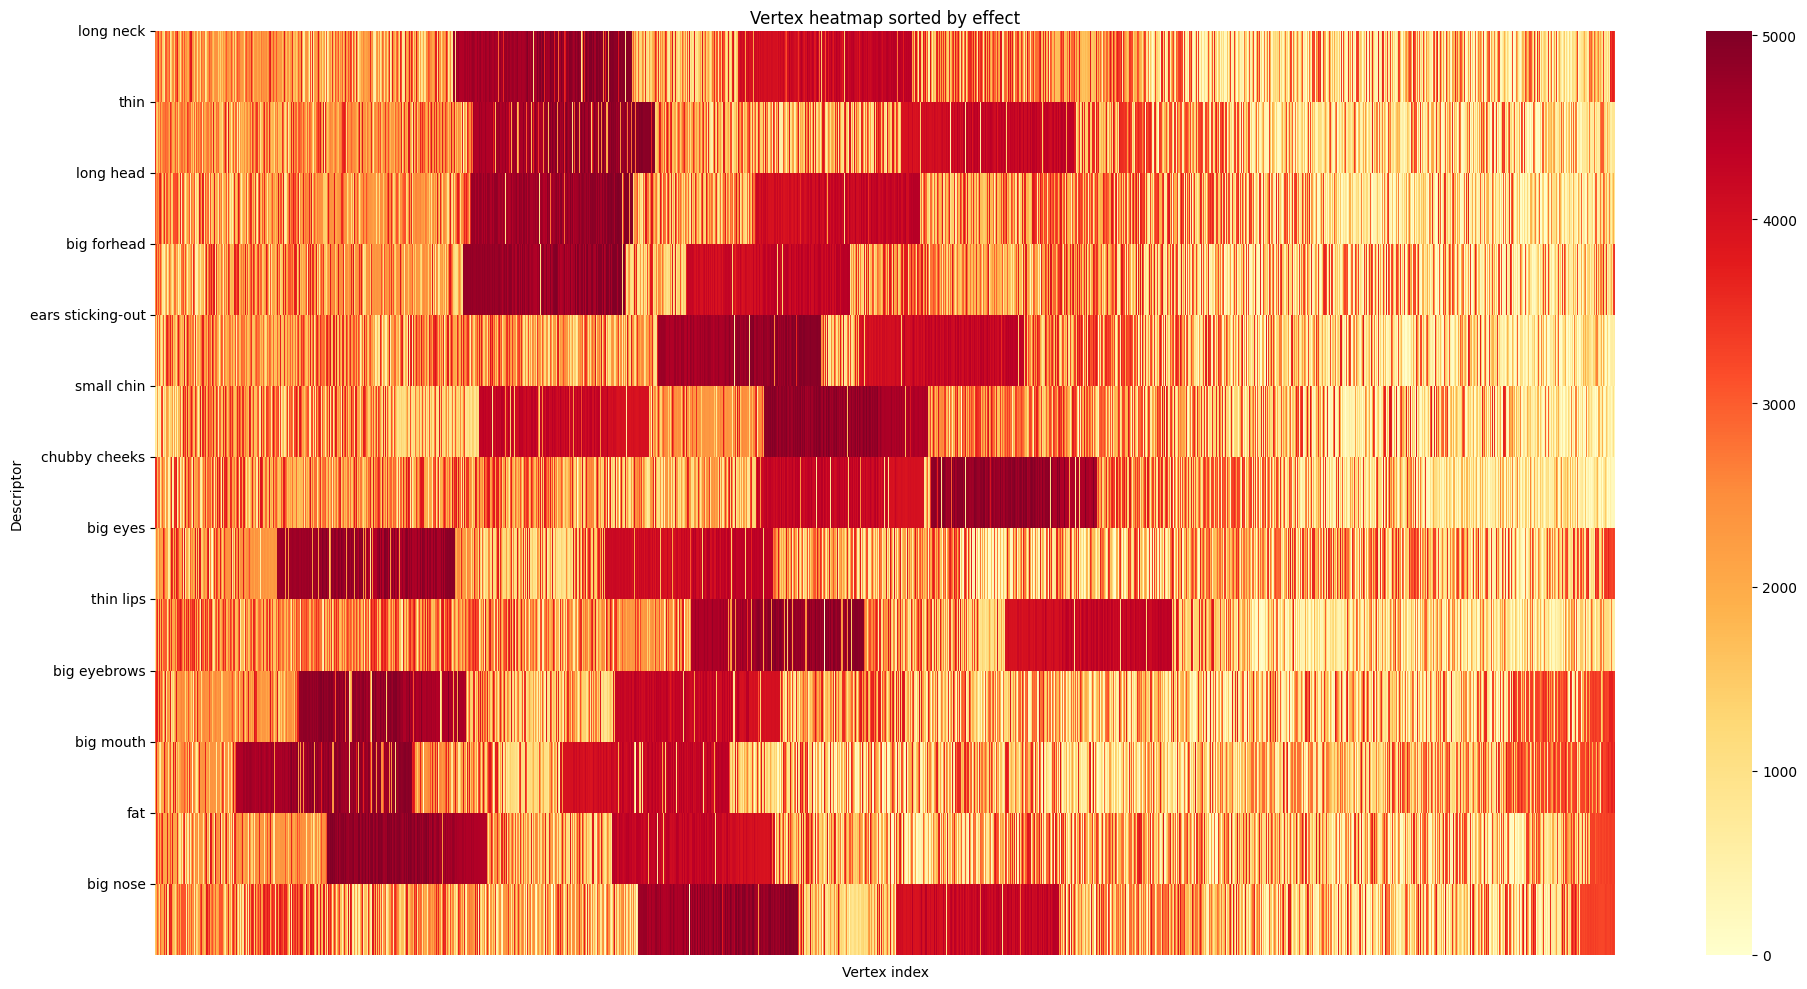

In [198]:
import seaborn as sns

fig = plt.figure(figsize=(20, 10))
ax = sns.heatmap(sorted_indices_values, cmap="YlOrRd")
plt.xlabel("Vertex index")
plt.ylabel("Descriptor")
plt.yticks(np.arange(len(df)), df["descriptor"].values)
plt.title("Vertex heatmap sorted by effect")
# rotate the y axis labels
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
plt.xticks([])
fig.tight_layout()


In [129]:
# from the plot above get for each descriptor, with which other descriptors it is overlapping
# for example, the descriptor "a person" is overlapping with "a person" and "a person sitting"
# so we can say that the descriptor "a person" is more general than "a person sitting"

# get the indices of the descriptors that are overlapping with each descriptor
overlapping_descriptors = []
for i in range(len(df)):
    overlapping_descriptors.append(np.where(sorted_indices_values[i] > 0)[0])



In [199]:
# calculate how many indices overlap between each descriptor by the order of the effect
# and plot the overlap as a heatmap
overlap = np.zeros((len(df), len(df)))
for i in range(len(df)):
    for j in range(len(df)):
        overlap[i, j] = (sorted_indices_values[i] == sorted_indices_values[j]).sum()



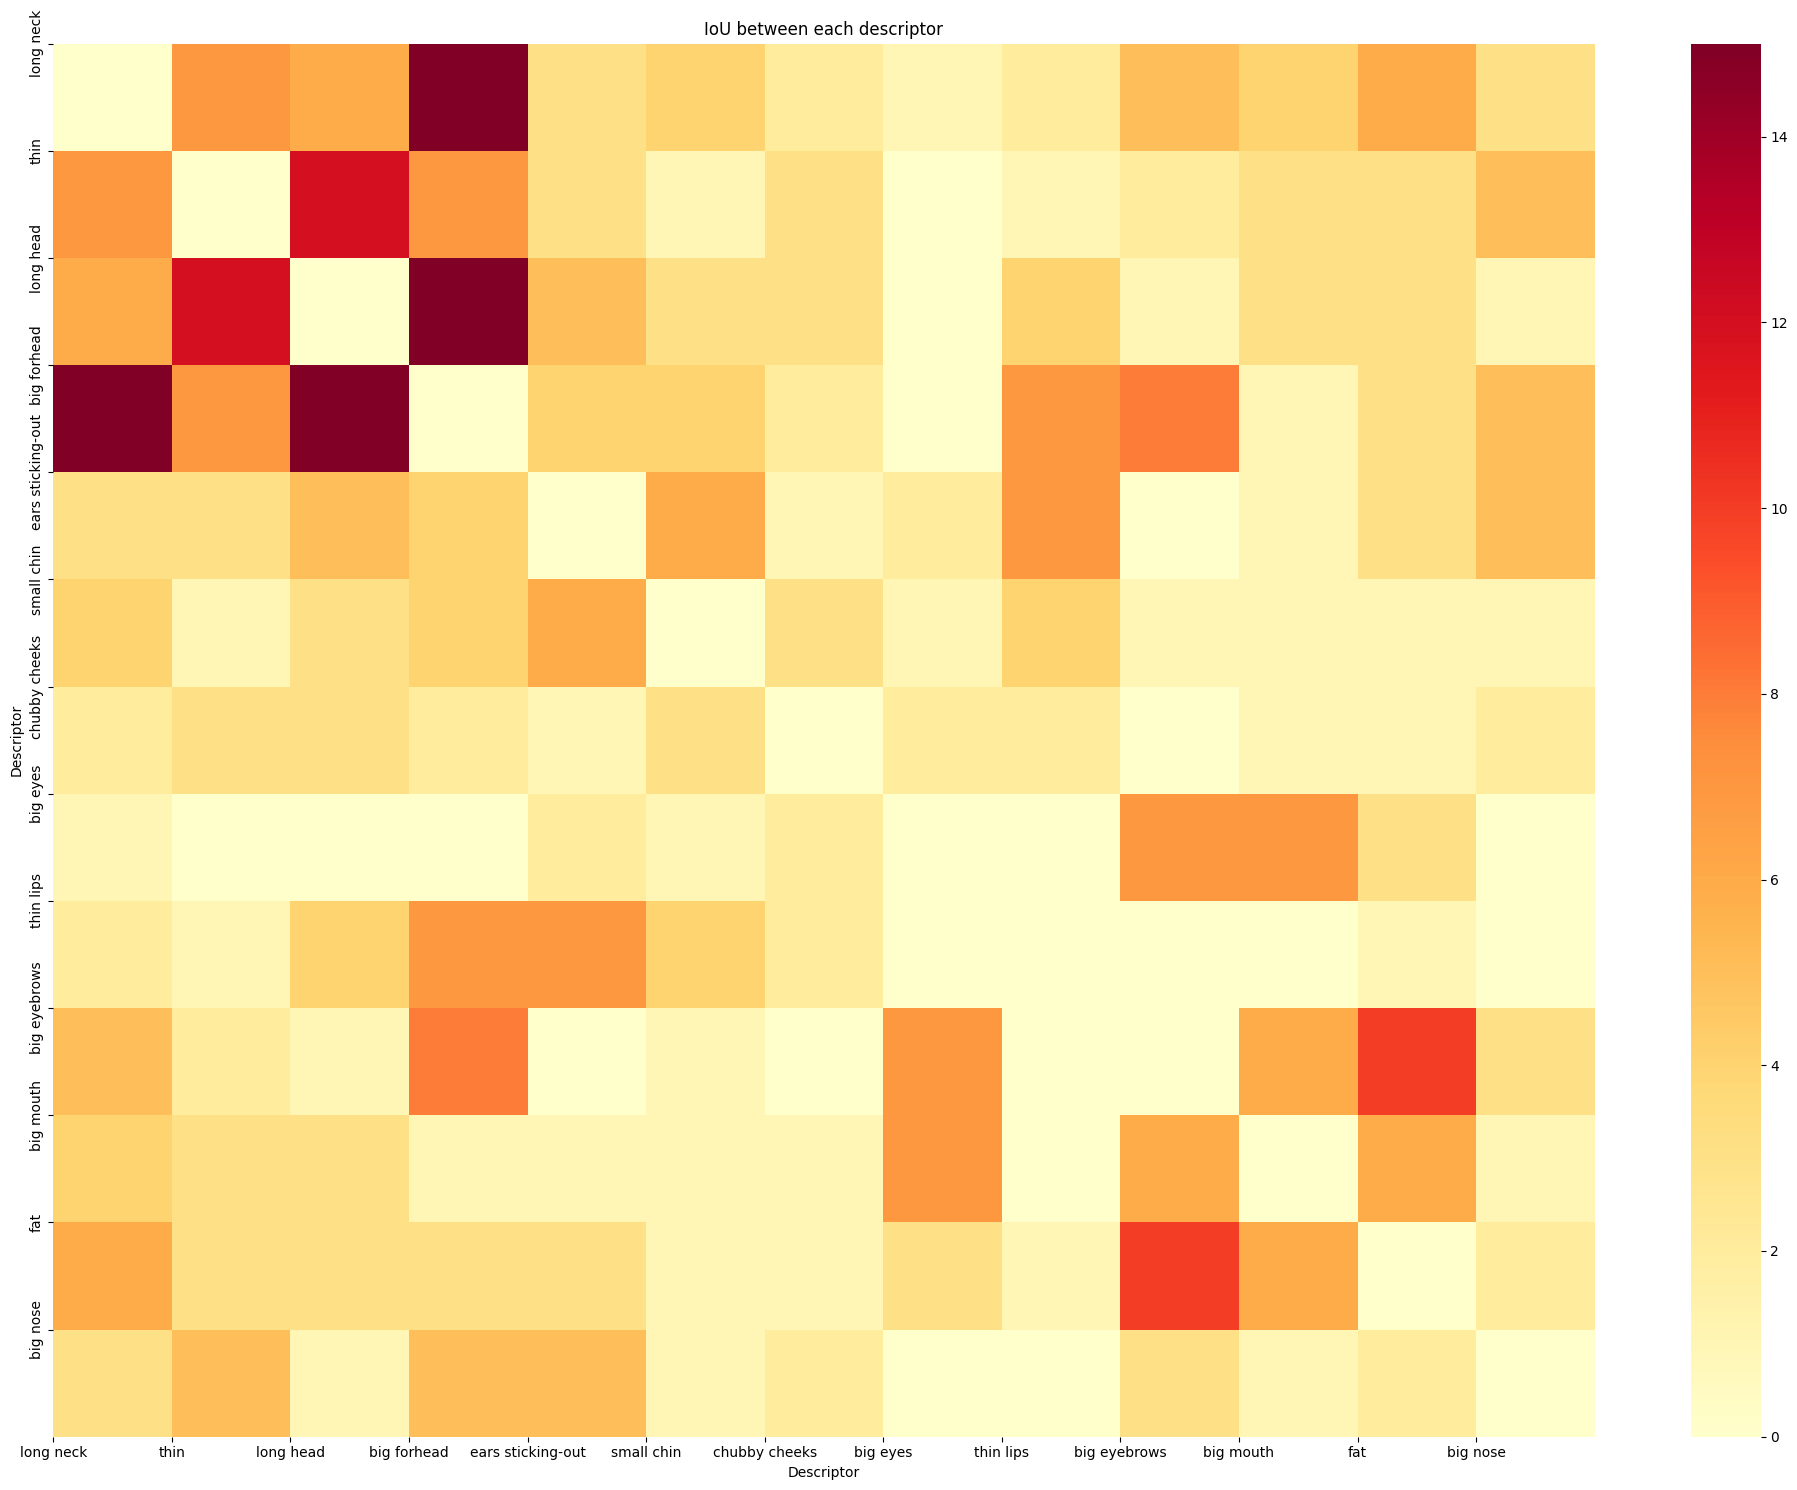

In [200]:
fig = plt.figure(figsize=(20, 15))
# put zeros on the diagonal
np.fill_diagonal(overlap, 0)
ax = sns.heatmap(overlap, cmap="YlOrRd")
plt.xlabel("Descriptor")
plt.ylabel("Descriptor")
plt.yticks(np.arange(len(df)), df["descriptor"].values)
plt.xticks(np.arange(len(df)), df["descriptor"].values)
plt.title("IoU between each descriptor")
fig.tight_layout()


In [194]:
# get upper triangle of the matrix
upper_traingle = np.tril(overlap, k=-1)

# get the indices of the descriptors that are overlapping with each descriptor
overlapping_descriptors = {}
for i, descriptor in enumerate(df["descriptor"].values):
    overlapping_descriptors[descriptor] = df["descriptor"][np.where(upper_traingle[i] > 0)[0]].values

# if there are any empty lists, remove them
overlapping_descriptors_dict = {k: v.tolist() for k, v in overlapping_descriptors.items() if len(v) > 0}
# overlapping_descriptors

descriptors_to_keep = []
descriptors_to_remove = []
for descriptor, overlapping_descriptors_list in overlapping_descriptors_dict.items():

    print("\ndescriptor:", descriptor, "|", "overlapping_descriptors:", overlapping_descriptors_list)

    descriptors_to_remove = []
    descriptors_effect = df[df["descriptor"] == descriptor]["effect"].values[0]
    
    for overlapped_descriptor in overlapping_descriptors_list:
        overlapped_descriptors_effect = df[df["descriptor"] == overlapped_descriptor]["effect"].values[0]
    
        if descriptors_effect > overlapped_descriptors_effect:
            print(f"{descriptor} is more general than {overlapped_descriptor}")
            descriptors_to_remove.append(overlapped_descriptor)
    
        else:
            print(f"{overlapped_descriptor} is more general than {descriptor}")
            descriptors_to_remove.append(descriptor)
            descriptors_to_keep.append(overlapped_descriptor)
    
            break
    
    if descriptor in overlapping_descriptors_dict.keys():
        if len(descriptors_to_remove) > 0:
            for descriptor_to_remove in descriptors_to_remove:
                overlapping_descriptors_dict[descriptor].pop(descriptor_to_remove)
        if len(overlapping_descriptors_list) == 0:
            descriptors_to_keep.append(descriptor)

for descriptor in descriptors_to_remove:
    overlapping_descriptors_dict.pop(descriptor)

print("\ndescriptors_to_keep", descriptors_to_keep)
overlapping_descriptors_dict


descriptor: thin | overlapping_descriptors: ['long neck']
long neck is more general than thin


RuntimeError: dictionary changed size during iteration

In [161]:
overlapping_descriptors = {}
for i, descriptor in enumerate(df["descriptor"].values):
    overlapping_descriptors[descriptor] = df["descriptor"][np.where(overlap[i] > 6)[0]].values
overlapping_descriptors


In [162]:
overlapping_descriptors

[array([1, 3]),
 array([0, 2, 3]),
 array([1, 3]),
 array([0, 1, 2, 8, 9]),
 array([8]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([ 9, 10]),
 array([3, 4]),
 array([ 3,  7, 11]),
 array([7]),
 array([9]),
 array([], dtype=int64)]

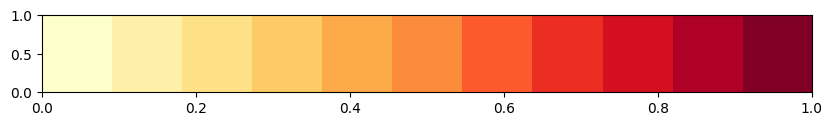

In [240]:
# show the YlOrRd colormap with the values between 0 and 1 in steps of 0.1
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

scale = np.linspace(0, 1, 11)
cmap = plt.get_cmap("YlOrRd")
fig = plt.figure(figsize=(10, 1))
plt.imshow([scale], cmap=cmap, aspect=0.1, extent=[0, 1, 0, 1])

fig.savefig("/home/nadav2/dev/data/CLIP2Shape/outs/vertices_heatmap/outs/plots/YlOrRd_colormap.png")


In [228]:
cmap = plt.get_cmap("YlOrRd")
normalized_distances_values = np.vstack([cmap(np.array(eval(df["normalized_distances"].values[i])))[None, ..., :3] for i in range(len(df))])
color_threshold = cmap(0.6)[:3]

In [239]:
# get the indices of the vertices that are above the color threshold
(normalized_distances_values[0] > color_threshold).all(axis=-1).sum()

3924